In [1]:
import json
import pathlib

from fastai.text import *

import numpy as np
import pandas as pd

# Data Preparation

In [2]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH = pathlib.Path("lm/telugu/data/")

In [3]:
LM_PATH=Path('lm/telugu/telugu_lm/')
LM_PATH.mkdir(exist_ok=True)

In [4]:
LANG_FILENAMES = [str(f) for f in PATH.rglob("*/*")]
print(len(LANG_FILENAMES))
LANG_FILENAMES[0:5]

482


['lm/telugu/data/AD/wiki_98',
 'lm/telugu/data/AD/wiki_83',
 'lm/telugu/data/AD/wiki_52',
 'lm/telugu/data/AD/wiki_82',
 'lm/telugu/data/AD/wiki_21']

In [91]:
LANG_TEXT = []
for i in LANG_FILENAMES:
    for line in open(i):
        LANG_TEXT.append(json.loads(line))
        
LANG_TEXT = pd.DataFrame(LANG_TEXT)

In [ ]:
LANG_TEXT.to_csv(f"{LM_PATH}/Wiki_Telugu_Corpus.csv", index=False)

In [6]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/Wiki_Telugu_Corpus.csv")

In [7]:
(LANG_TEXT.assign(labels = 0)
    .pipe(lambda x: x[['labels', 'text']])
    .to_csv(f"{LM_PATH}/Wiki_Telugu_Corpus2.csv", header=None, index=False))

# Some statistics of Telugu Wikipedia

In [8]:
# Getting rid of the title name in the text field
def split_title_from_text(text):
    words = text.split("\n\n")
    if len(words) >= 2:
        return ''.join(words[1:])
    else:
        return ''.join(words)
    
LANG_TEXT['text'] = LANG_TEXT['text'].apply(lambda x: split_title_from_text(x))

### Number of documents

In [9]:
LANG_TEXT.shape

(69001, 4)

### Number of words in all the documents

In [10]:
LANG_TEXT['text'].apply(lambda x: len(x.split(" "))).sum()

22174830

### Number of unique tokens across documents

In [11]:
len(set(''.join(LANG_TEXT['text'].values).split(" ")))

2023536

In [12]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    #texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts)) # splits the list into sublists for processing by each core
    # Lower and upper case is inside the tokenizer
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        #pdb.set_trace()
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [13]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/Wiki_Telugu_Corpus2.csv", header=None)#, chunksize=5000)

In [14]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    LANG_TEXT, test_size=0.1) # split the data into train and validation sets

In [15]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts)) # generate a random ordering
val_idx = np.random.permutation(len(val_texts))

df_trn = trn_texts.iloc[trn_idx,:] # sort things randomly
df_val = val_texts.iloc[val_idx,:] # sort things randomly

df_trn.columns = ['labels', 'text']
df_val.columns = ['labels', 'text']

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False) # saving the data in our new format to disk

In [16]:
chunksize = 10000
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [17]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
4
5
6
0


In [18]:
# create a tmp directory to store the upcoming numpy arrays
(LM_PATH/'tmp').mkdir(exist_ok=True)

# save the train and validation tokens in the tmp directories
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [19]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [20]:
# Identify the most common tokens and numericalizing the text
freq = Counter(p for o in tok_trn for p in o) 
freq.most_common(25)

[(',', 1410788),
 ('\n', 672357),
 ('\n\n', 436738),
 ('నుండి', 375347),
 ('ఉన్నాయి.', 307264),
 ('గ్రామం', 253259),
 ('దూరంలో', 253231),
 ('ఉంది.', 252353),
 ('10', 220495),
 ('గ్రామంలో', 190133),
 ('"', 184425),
 ('ఈ', 172379),
 ('మరియు', 171640),
 ('(', 156057),
 ('కి.మీ.', 155028),
 (')', 153247),
 ('5', 146159),
 ('కేంద్రం', 136949),
 ('సమీప', 133600),
 ('.', 121355),
 ('ఒక', 106164),
 ('సౌకర్యం', 94088),
 ('ద్వారా', 89868),
 ('కూడా', 89271),
 ('పైబడిన', 86061)]

In [21]:
# Truncating our vocab to ignore the rare words
max_vocab = 60000
min_freq = 5

itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq] # getting rid of the rare words
itos.insert(0, '_pad_') # 
itos.insert(0, '_unk_') # itos is the list of all the strings in the vocab

In [22]:
# creating a index-key dictionary for our vocabulary
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [23]:
# creating a index representation for our train and validation dataset
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [24]:
# saving our indexed representation of our dataset to disk
# we also save the index-word mapping to retrieve the complete text representation from these numpy arrays
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [25]:
# Loading the indexed representation of our dataset from disk
# we also load the index-word mapping to to help us convert the indexes to word datasets, if need be.
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [26]:
# checking vocabulary size
vs=len(itos)
vs,len(trn_lm)

(60002, 62100)

# Model Setup

In [32]:
# ! wget -nH -r -np http://files.fast.ai/models/wt103/
# mv models/ {LM_PATH}

In [27]:
em_sz,nh,nl = 400,1150,3

PRE_PATH = LM_PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

# itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb')) # mapping the itos from wiki to our own mapping
# stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [9]:
# we train from scratch so these are unused
# wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

# enc_wgts = to_np(wgts['0.encoder.weight'])
# row_m = enc_wgts.mean(0)

# wgts['0.encoder.weight'] = T(new_w)
# wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
# wgts['1.decoder.weight'] = T(np.copy(new_w))

# Language Model

In [28]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [29]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [30]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7 # if you're overfitting, increase this. Underfitting? decrease this.

In [31]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.clip = 0.2
learner.unfreeze()

In [32]:
lr=1e-3
lrs = lr

In [33]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1) # last layer is the embedding weights

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      3.674542   3.356561   0.559592  



[array([3.35656]), 0.5595924010984453]

In [34]:
learner.save('lm_telugu_v2')

In [35]:
learner.load('lm_telugu_v2')

In [36]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      6.597806   6.047346   0.231769  



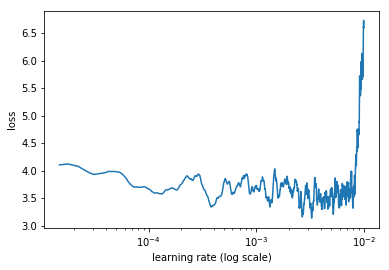

In [37]:
learner.sched.plot()

In [38]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      3.364024   3.061188   0.574934  



[array([3.06119]), 0.574934254323728]

In [39]:
learner.save('lm_telugu_v2_2')

In [40]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      3.218694   3.043627   0.572854  
    1      3.107684   2.965055   0.576521                     
    2      3.107444   2.90975    0.580561                     
    3      3.075227   2.874818   0.583068                     
    4      3.049952   2.849801   0.585276                     
    5      3.023235   2.833511   0.586686                     
    6      2.99841    2.817971   0.588222                     
    7      3.001799   2.809355   0.588838                     
    8      2.981449   2.794863   0.590403                     
    9      2.948724   2.782556   0.591681                     
    10     2.951283   2.773459   0.592407                     
    11     2.917901   2.765038   0.593081                     
    12     2.887185   2.756081   0.593963                     
    13     2.918406   2.751016   0.594492                     
    14     2.845357   2.742368   0.59524                      



[array([2.74237]), 0.5952399933766711]

In [41]:
learner.save('lm_telugu_v2_3')

In [42]:
learner.save_encoder('lm_telugu_v2_3_enc')

### Generate text

In [43]:
learner.load("lm_telugu3")

In [44]:
m = learner.model
m.eval()
m[0].bs = 1

## Inference

In [45]:
sen = """ఈ కేంద్రం నుండి"""

In [46]:
idxs = np.array([[stoi[p] for p in sen.strip().split(" ")]])
idxs

array([[13, 19,  5]])

In [47]:
VV(idxs)

Variable containing:
 13  19   5
[torch.cuda.LongTensor of size 1x3 (GPU 0)]

In [48]:
probs = learner.model(VV(idxs))

In [49]:
type(probs), len(probs)

(tuple, 3)

In [50]:
learner.model

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150, dropout=0.105)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150, dropout=0.105)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400, dropout=0.105)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60002, bias=False)
    (dropout): LockedDropout(
    )
  )
)

In [51]:
probs[0].shape, [x.shape for x in probs[1]], [x.shape for x in probs[2]]

(torch.Size([3, 60002]),
 [torch.Size([1, 3, 1150]), torch.Size([1, 3, 1150]), torch.Size([1, 3, 400])],
 [torch.Size([1, 3, 1150]), torch.Size([1, 3, 1150]), torch.Size([1, 3, 400])])

In [30]:
# probs[0] is most likely the output vector

### Arvind's answer

In [52]:
def get_next(inp):
#     m[0].bs = 1 ## why?
    idxs = np.array([[stoi[p] for p in inp.strip().split(" ")]])
    p = m(VV(idxs))
    #pdb.set_trace()
    i = np.argmax(to_np(p)[0], 1)[0]
    try:
        r = itos[i]
    except:
        r = "oor"
    return r

def get_next(inp):
    idxs = np.array([[stoi[p] for p in inp.strip().split(" ")]])
    p = m(VV(idxs))
    #i = np.argmax(to_np(p)[0], 1)[0]
    i = torch.topk(p[0][-1], 1)[1].data[0]
    try:
        r = itos[i]
    except:
        r = "oor"
    return r

def get_next(inp):
    m[0].bs =1
    #print(inp)
    idxs = np.array([[stoi[p] for p in inp.strip().split(" ")]])
    probs = m(VV(idxs))
    encc = probs[-1][-1][-1][-1].squeeze()
    pred = to_np(learner.model[1].decoder(encc).exp()).argmax()
    try:
        r = itos[pred]
    except:
        r = "oor"
    return r


def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        # res += c # ???
        res = res + " " + c
        #print(res)
        inp = inp.strip().split(" ") + [c]        
#         inp = ' '.join(inp[1:])
        inp = ' '.join(inp)
        
    return res

In [312]:
m = learner.model
m.eval()
m[0].bs = 1

In [53]:
sen = """ఈ కేంద్రం"""
get_next_n(sen, 10)

'ఈ కేంద్రం నుండి _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_'

In [54]:
sen = """ఒక సౌకర్యం"""
get_next_n(sen, 10)


'ఒక సౌకర్యం కోసం _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_'

In [55]:
sen = """సౌకర్యం కూడా"""
get_next_n(sen, 10)

'సౌకర్యం కూడా _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_'

# Classifier Tokens

In [56]:
CLAS_PATH = Path("lm/telugu/telugu_clas/")
LM_PATH.mkdir(exist_ok=True)

In [57]:
df_clas_data = pd.read_csv(CLAS_PATH/"ACTSA_telugu_polarity_annotated_UTF.txt", sep="\t", header=None)
df_clas_data[1] = df_clas_data[0].str[2:]
df_clas_data[0] = df_clas_data[0].str[0:2]

# Cleaning the target
df_clas_data[0] = df_clas_data[0].str.strip()
df_clas_data = df_clas_data[df_clas_data[0] != '+'].reset_index(drop=True)
df_clas_data[0] = df_clas_data[0].astype(np.float32)

df_clas_data.to_csv(CLAS_PATH/"Telugu_Sentiment_Data.csv", index=False)

# Ignoring neutral class for this exercise
df_clas_data = df_clas_data[df_clas_data[0] != 0].reset_index(drop=True)

# Creating train and validation sets
np.random.seed(42)
trn_keep = np.random.rand(len(df_clas_data))>0.1
df_trn = df_clas_data[trn_keep]
df_val = df_clas_data[~trn_keep]

# Saving train and validation sets to disk
df_trn.to_csv(CLAS_PATH/"Telugu_Sentiment_Data_Train.csv", header=None, index=False)
df_val.to_csv(CLAS_PATH/"Telugu_Sentiment_Data_Test.csv", header=None, index=False)

len(df_trn),len(df_val)

(2615, 315)

In [58]:
chunksize = 10000
df_trn = pd.read_csv(CLAS_PATH/"Telugu_Sentiment_Data_Train.csv", header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/"Telugu_Sentiment_Data_Test.csv", header=None, chunksize=chunksize)

In [59]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
0


In [60]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [61]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [62]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [63]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [64]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

# Classifier

In [65]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [66]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [67]:
Counter(trn_labels)

Counter({-1: 1290, 1: 1325})

In [68]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [69]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [70]:
c

3

In [71]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [72]:
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [73]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [74]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [75]:
m

SequentialRNN(
  (0): MultiBatchRNN(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150, dropout=0.3)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150, dropout=0.3)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400, dropout=0.3)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): ModuleList(
      (0): LinearBlock(
        (lin): Linear(in_features=1200, out_features=50, bias=True)
        (drop): Dropout(p=0.1)
        (bn): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): LinearBlock(
        (lin): Linear(in_features=50, out_features=3, bias=True)
        (drop): 

In [ ]:
# learner= md.get_model(opt_fn, em_sz, nh, nl, 
#     dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

# learner.metrics = [accuracy]
# learner.unfreeze()

In [76]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [77]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [78]:
learner

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150, dropout=0.105)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150, dropout=0.105)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400, dropout=0.105)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60002, bias=False)
    (dropout): LockedDropout(
    )
  )
)

In [79]:
wd = 1e-7
wd = 0
learn.load_encoder('lm_telugu_v2_3_enc')

In [80]:
learn.freeze_to(-1)

In [81]:
learn.lr_find(lrs/1000)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 83%|████████▎ | 90/109 [00:01<00:00, 64.73it/s, loss=4.43] 


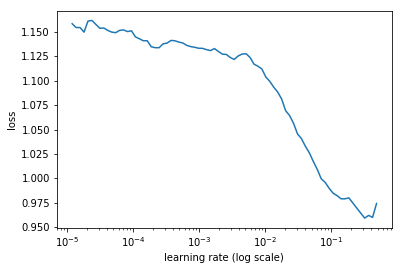

In [82]:
learn.sched.plot()

In [83]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8, 3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.805629   0.690575   0.638916  



[array([0.69057]), 0.6389158056225888]

In [84]:
learn.save('clas_0')

In [85]:
learn.load('clas_0')

In [86]:
learn.freeze_to(-2)

In [87]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8, 3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.666295   0.616798   0.644689  



[array([0.6168]), 0.6446893987960594]

In [88]:
learn.unfreeze()

In [89]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32, 10))

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.642292   0.613381   0.648956  
    1      0.637285   0.596132   0.654797                    
    2      0.622529   0.577279   0.648323                    
    3      0.592932   0.564014   0.689317                    
    4      0.595894   0.547979   0.648646                    
    5      0.568898   0.5325     0.712384                    
    6      0.564322   0.523673   0.719867                    
    7      0.541882   0.50829    0.70766                     
    8      0.525401   0.503269   0.72307                     
    9      0.532941   0.499391   0.706866                    
    10     0.535057   0.502889   0.719611                    
    11     0.511008   0.499853   0.727404                    
    12     0.500359   0.498179   0.731522                    
    13     0.48697    0.500104   0.724981                    



[array([0.5001]), 0.7249811589717865]

In [90]:
learn.save('clas_1')